# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
from skimage import feature as skft
def Lbp(img):
    # settings for LBP
    radius = 1
    n_points = 8 * radius
    lbp = skft.local_binary_pattern(img, n_points, radius, 'default') # ‘default’, ‘ror’, ‘uniform’, ‘var’
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, normed=True, bins=n_bins, range=(0, n_bins))
    return hist

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    
    
    num_dev 是开发是否使用的部分数据，比如测试loss是否正常，比较数据梯度和逻辑梯度之间的差异，比较向量化和没有向量化时候的时间对比
    
    
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/Users/apple/cifar-10-batches-py/cifar10-data'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

 
    
#     print(X_train.shape) (50000,32,32,3)
#     print(y_train.shape) (50000,1)

    # subsample the data
    # 取出一小部分的
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    
    #每个维度的平均值 axis=0代表 列平均
    mean_image = np.mean(X_train, axis = 0)
    print(mean_image.shape)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

(3072,)
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.304433
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *因为有十个类别，而上述的W是random出来的，所以只有对于任意一个W，计算测试数据集，得出的结果都是1/10，才能说明这套loss定义有效*


In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.504060 analytic: -0.504060, relative error: 4.847405e-08
numerical: 1.733284 analytic: 1.733284, relative error: 2.587422e-08
numerical: -0.453426 analytic: -0.453426, relative error: 1.372159e-07
numerical: -0.223028 analytic: -0.223028, relative error: 6.737169e-10
numerical: 0.928589 analytic: 0.928589, relative error: 2.760284e-08
numerical: 2.215537 analytic: 2.215537, relative error: 2.480473e-09
numerical: 0.833940 analytic: 0.833939, relative error: 4.556612e-08
numerical: -0.448587 analytic: -0.448587, relative error: 8.925013e-08
numerical: 2.218322 analytic: 2.218322, relative error: 6.844514e-09
numerical: 1.485895 analytic: 1.485895, relative error: 1.428730e-08
numerical: 0.129984 analytic: 0.129984, relative error: 1.493478e-07
numerical: 0.288810 analytic: 0.288809, relative error: 4.331705e-08
numerical: -0.987035 analytic: -0.987035, relative error: 4.897272e-08
numerical: -0.148772 analytic: -0.148773, relative error: 1.877787e-07
numerical: -2.442597 a

In [8]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.304433e+00 computed in 0.162159s
vectorized loss: 2.304433e+00 computed in 0.004841s
Loss difference: 0.000000
Gradient difference: 0.000000


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [5e-8,1e-8, 5e-7]
regularization_strengths = [2.5e1,2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=10000, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 10000: loss 6.501573
iteration 100 / 10000: loss 5.355311
iteration 200 / 10000: loss 4.843101
iteration 300 / 10000: loss 4.730751
iteration 400 / 10000: loss 4.205755
iteration 500 / 10000: loss 4.192288
iteration 600 / 10000: loss 4.367562
iteration 700 / 10000: loss 4.119366
iteration 800 / 10000: loss 4.051233
iteration 900 / 10000: loss 3.536127
iteration 1000 / 10000: loss 3.998613
iteration 1100 / 10000: loss 3.598073
iteration 1200 / 10000: loss 3.786977
iteration 1300 / 10000: loss 3.670595
iteration 1400 / 10000: loss 3.591565
iteration 1500 / 10000: loss 3.755508
iteration 1600 / 10000: loss 3.666162
iteration 1700 / 10000: loss 3.486321
iteration 1800 / 10000: loss 3.264417
iteration 1900 / 10000: loss 3.552073
iteration 2000 / 10000: loss 3.402328
iteration 2100 / 10000: loss 3.334564
iteration 2200 / 10000: loss 3.440044
iteration 2300 / 10000: loss 3.404927
iteration 2400 / 10000: loss 3.781884
iteration 2500 / 10000: loss 3.458573
iteration 2600 / 10000: 

iteration 1600 / 10000: loss 2.139131
iteration 1700 / 10000: loss 2.132533
iteration 1800 / 10000: loss 2.174168
iteration 1900 / 10000: loss 2.141471
iteration 2000 / 10000: loss 2.141253
iteration 2100 / 10000: loss 2.128154
iteration 2200 / 10000: loss 2.133892
iteration 2300 / 10000: loss 2.106174
iteration 2400 / 10000: loss 2.096067
iteration 2500 / 10000: loss 2.154349
iteration 2600 / 10000: loss 2.156271
iteration 2700 / 10000: loss 2.166093
iteration 2800 / 10000: loss 2.122886
iteration 2900 / 10000: loss 2.086837
iteration 3000 / 10000: loss 2.186983
iteration 3100 / 10000: loss 2.144373
iteration 3200 / 10000: loss 2.166337
iteration 3300 / 10000: loss 2.143214
iteration 3400 / 10000: loss 2.156784
iteration 3500 / 10000: loss 2.129017
iteration 3600 / 10000: loss 2.126836
iteration 3700 / 10000: loss 2.138318
iteration 3800 / 10000: loss 2.150151
iteration 3900 / 10000: loss 2.113497
iteration 4000 / 10000: loss 2.171213
iteration 4100 / 10000: loss 2.112978
iteration 42

iteration 3200 / 10000: loss 33.567889
iteration 3300 / 10000: loss 30.563586
iteration 3400 / 10000: loss 27.847043
iteration 3500 / 10000: loss 25.352049
iteration 3600 / 10000: loss 23.122593
iteration 3700 / 10000: loss 21.132164
iteration 3800 / 10000: loss 19.290558
iteration 3900 / 10000: loss 17.630835
iteration 4000 / 10000: loss 16.223429
iteration 4100 / 10000: loss 14.812962
iteration 4200 / 10000: loss 13.659568
iteration 4300 / 10000: loss 12.571046
iteration 4400 / 10000: loss 11.504418
iteration 4500 / 10000: loss 10.669469
iteration 4600 / 10000: loss 9.812551
iteration 4700 / 10000: loss 9.161447
iteration 4800 / 10000: loss 8.378582
iteration 4900 / 10000: loss 7.808522
iteration 5000 / 10000: loss 7.277740
iteration 5100 / 10000: loss 6.768367
iteration 5200 / 10000: loss 6.314900
iteration 5300 / 10000: loss 5.948955
iteration 5400 / 10000: loss 5.515107
iteration 5500 / 10000: loss 5.272768
iteration 5600 / 10000: loss 4.874905
iteration 5700 / 10000: loss 4.65604

iteration 4700 / 10000: loss 2.396425
iteration 4800 / 10000: loss 2.254152
iteration 4900 / 10000: loss 2.564411
iteration 5000 / 10000: loss 2.360894
iteration 5100 / 10000: loss 2.296440
iteration 5200 / 10000: loss 2.289261
iteration 5300 / 10000: loss 2.407842
iteration 5400 / 10000: loss 2.245170
iteration 5500 / 10000: loss 2.410964
iteration 5600 / 10000: loss 2.460819
iteration 5700 / 10000: loss 2.340102
iteration 5800 / 10000: loss 2.332356
iteration 5900 / 10000: loss 2.251150
iteration 6000 / 10000: loss 2.365760
iteration 6100 / 10000: loss 2.314418
iteration 6200 / 10000: loss 2.305193
iteration 6300 / 10000: loss 2.258576
iteration 6400 / 10000: loss 2.299147
iteration 6500 / 10000: loss 2.336758
iteration 6600 / 10000: loss 2.279198
iteration 6700 / 10000: loss 2.201661
iteration 6800 / 10000: loss 2.225110
iteration 6900 / 10000: loss 2.260143
iteration 7000 / 10000: loss 2.138748
iteration 7100 / 10000: loss 2.172433
iteration 7200 / 10000: loss 2.223640
iteration 73

iteration 6400 / 10000: loss 2.155900
iteration 6500 / 10000: loss 2.165738
iteration 6600 / 10000: loss 2.165265
iteration 6700 / 10000: loss 2.154801
iteration 6800 / 10000: loss 2.177551
iteration 6900 / 10000: loss 2.134963
iteration 7000 / 10000: loss 2.128928
iteration 7100 / 10000: loss 2.111428
iteration 7200 / 10000: loss 2.132019
iteration 7300 / 10000: loss 2.120270
iteration 7400 / 10000: loss 2.141742
iteration 7500 / 10000: loss 2.122731
iteration 7600 / 10000: loss 2.174926
iteration 7700 / 10000: loss 2.172520
iteration 7800 / 10000: loss 2.147703
iteration 7900 / 10000: loss 2.140003
iteration 8000 / 10000: loss 2.185110
iteration 8100 / 10000: loss 2.134129
iteration 8200 / 10000: loss 2.176173
iteration 8300 / 10000: loss 2.215702
iteration 8400 / 10000: loss 2.144241
iteration 8500 / 10000: loss 2.116262
iteration 8600 / 10000: loss 2.146730
iteration 8700 / 10000: loss 2.176335
iteration 8800 / 10000: loss 2.155505
iteration 8900 / 10000: loss 2.186158
iteration 90

In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.377000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

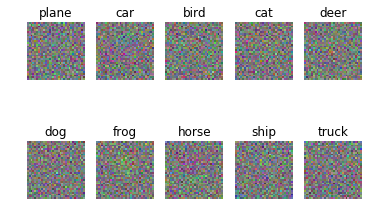

In [11]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [12]:
import numpy as np

b=np.ones((10,10))
a=np.arange(100).reshape(10,10)
c=np.mean(a,axis=0)
print(c)
d=np.mean(b,axis=1)
print(d)

[45. 46. 47. 48. 49. 50. 51. 52. 53. 54.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
